In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy
import torchvision.models as models
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.autograd import Variable
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(),
                               transforms.RandomRotation(30)])


In [3]:
train_dataset = datasets.ImageFolder(
    r"data/train", transform=transform)
test_dataset = datasets.ImageFolder(
    r"data/test", transform=transform)
class_name = train_dataset.classes
print(class_name)


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=10)

Label: [3 0 3 4 0 2 0 0 3 3]
Class: happy angry happy neutral angry fear angry angry happy happy


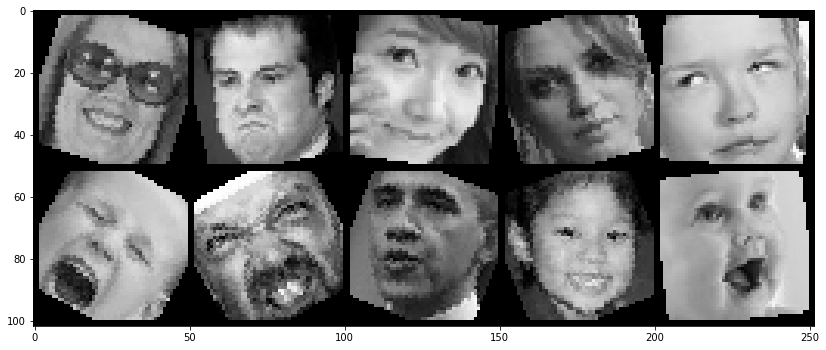

In [5]:
for image, label in train_loader:
    break

print('Label:', label.numpy())
print('Class:', *np.array([class_name[i] for i in label]))

# the default nrow is 8
im = make_grid(image, nrow=5)  

# Print the images
plt.figure(figsize=(14,6))
plt.imshow(np.transpose(im, (1, 2, 0)))

In [6]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(59536, 210)
        self.fc_2 = nn.Linear(210, 147)
        self.fc_3 = nn.Linear(147, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        return x


In [7]:
model = ConvolutionalNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /home/mystic/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100.0%


In [8]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

  1728
    64
 36864
    64
 73728
   128
147456
   128
294912
   256
589824
   256
1179648
   512
2359296
   512
2359296
   512
2359296
   512
102760448
  4096
16777216
  4096
4096000
  1000
______
133047848


In [9]:
len(test_loader)

718

In [10]:
len(train_loader)

2871

In [11]:
def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0
    tst_corr = 0
    # Test validation data
    with torch.no_grad():
        for x_test, y_test in valid_loader:
            input = x_test.to(device)
            label = y_test.to(device)

            y_pred = model(input).to(device)
            predicted = torch.max(y_pred.data, 1)[1]
            loss = loss_function(y_pred, label)
            loss_total += loss.item()
            tst_corr += (predicted == label).sum()/len(label)

    return loss_total / len(valid_loader), tst_corr.item()/len(valid_loader)


In [12]:
epoch = 30
last_loss = 100
patience = float('inf')
triggertimes = 0
losses = []
train_losses = []
train_correct = []
test_losses = []
test_correct = []
max_model = copy.deepcopy(model)
max_acc = 0
for i in range(epoch):
    trn_corr = 0
    tst_corr = 0
    for b,(x_train, y_train) in enumerate(train_loader):
        b += 1

        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model(x_train).to(device)
        loss = criterion(y_pred,y_train)
     
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(len(train_loader)//4) == 0:
            print(
                f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_loader)*10}]  Train Loss: {loss.item():10.8f} train_acc.: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    current_loss, tst_acc = validation(model, device, test_loader, criterion)
    print('Val_Loss:', round(current_loss, 8), 'Val_acc:', round(tst_acc*100, 2))
    if round(tst_acc*100, 2)>max_acc:
        max_model = copy.deepcopy(model)
        max_acc = round(tst_acc*100, 2)
    if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
    else:
        print('trigger times: 0')
        trigger_times = 0

    last_loss = current_loss
    
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            X_test, y_test = X_test.to(device), y_test.to(device)
            # Apply the model
            y_val = model(X_test).to(device)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

In [ ]:
submission = pd.read_csv("data/test.csv")
predictions = []
for img_path in submission["path"]:
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze_(0) #so img is not treated as a batch 
    input_img = Variable(image_tensor).to(device)
    output = max_model(input_img).cpu()
    #print(output)
    index = output.data.numpy().argmax()
    pred = class_name[index]
    predictions.append(pred)

submission["label"] = predictions
submission.to_csv("submission.csv", index=False)